# MIMIC-II Causal Inference

This tutorial continues the exploration the MIMIC-II IAC dataset using causal inference methods. It was created for the purpose of a case study in the book: Secondary Analysis of Electronic Health Records, published by Springer in 2016. In particular, the dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. The dataset is derived from MIMIC-II, the publicly-accessible critical care database. It contains summary clinical data and  outcomes for 1,776 patients.

Reference: 

[1] Critical Data, M.I.T., 2016. Secondary analysis of electronic health records (p. 427). Springer Nature. (https://link.springer.com/book/10.1007/978-3-319-43742-2)

[2] https://github.com/MIT-LCP/critical-data-book/tree/master/part_ii/chapter_16/jupyter

[3] https://stackoverflow.com/questions/27328623/anova-test-for-glm-in-python/60769343#60769343

## Importing ehrapy and setting plotting parameters

In [1]:
import ehrapy as ep
import dowhy
import econml
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import graphviz
import dowhy.datasets

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet connection?

/Users/tim.treis/anaconda3/envs/ehrapy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
ep.print_versions()

-----
ehrapy              0.4.0
rich                NA
session_info        1.0.0
-----
Levenshtein                 0.20.9
PIL                         9.4.0
anndata                     0.9.1
appnope                     0.1.2
astor                       0.8.1
asttokens                   NA
attr                        22.1.0
autograd                    NA
autograd_gamma              NA
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
bs4                         4.12.2
cachetools                  5.3.0
category_encoders           2.6.0
certifi                     2023.05.07
cffi                        1.15.1
charset_normalizer          3.1.0
cloudpickle                 2.2.1
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
db_dtypes                   1.1.1
debugpy                     1.5.1
decorator                   5.1.1
deep_translator             1.9.1
deepl                       1.14.0
defusedxml                  0.7.1
dowhy                       0.9.1
econml                      0.14.0
entrypoints                 0.4
executing                   0.8.3
fhiry                       3.0.0
formulaic                   0.6.1
future                      0.18.3
google                      NA
graphlib                    NA
graphviz                    0.20.1
grpc                        1.54.0
grpc_status                 NA
h5py                        3.8.0
hypergeom_ufunc             NA
idna                        3.4
igraph                      0.10.4
interface_meta              1.3.0
ipykernel                   6.15.2
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
lifelines                   0.27.7
llvmlite                    0.39.1
matplotlib                  3.7.1
missingno                   0.5.2
mpl_toolkits                NA
mpmath                      1.3.0
mudata                      0.2.2
natsort                     8.3.1
nbinom_ufunc                NA
ncf_ufunc                   NA
networkx                    2.8.8
numba                       0.56.4
numexpr                     2.8.4
numpy                       1.23.5
packaging                   23.0
pandas                      1.5.3
parso                       0.8.3
patsy                       0.5.3
pexpect                     4.8.0
pickleshare                 0.7.5
pkg_resources               NA
prompt_toolkit              3.0.20
psutil                      5.9.0
ptyprocess                  0.7.0
pure_eval                   0.2.2
pyarrow                     12.0.0
pyasn1                      0.5.0
pyasn1_modules              0.3.0
pydantic                    1.10.7
pydev_ipython               NA
pydevconsole                NA
pydevd                      2.6.0
pydevd_concurrency_analyser NA
pydevd_file_utils           NA
pydevd_plugins              NA
pydevd_tracing              NA
pygments                    2.15.1
pyhpo                       3.1.5
pyparsing                   3.0.9
pypi_latest                 0.1.2
pytz                        2023.3
questionary                 1.10.0
rapidfuzz                   2.15.1
requests                    2.30.0
rsa                         4.9
scanpy                      1.9.3
scipy                       1.9.3
seaborn                     0.12.2
setuptools                  66.0.0
six                         1.16.0
sklearn                     1.1.3
soupsieve                   2.4.1
sparse                      0.14.0
sphinxcontrib               NA
stack_data                  0.2.0
statsmodels                 0.13.5
sympy                       1.11.1
texttable                   1.6.7
thefuzz                     0.19.0
threadpoolctl               3.1.0
tornado                     6.2
tqdm                        4.65.0
traitlets                   5.1.1
typing

## MIMIC-II dataset preparation

In [4]:
adata = ep.dt.mimic_2(encoded=True)

2023-05-08 16:21:22,063 - root INFO - Added all columns to `obs`.
2023-05-08 16:21:22,072 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `1776` x `46`.
2023-05-08 16:21:22,072 - root INFO - The original categorical values `['day_icu_intime', 'service_unit']` were added to uns.
2023-05-08 16:21:22,076 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.
2023-05-08 16:21:22,078 - root INFO - Updated the original layer after encoding.
2023-05-08 16:21:22,084 - root INFO - The original categorical values `['day_icu_intime', 'service_unit']` were added to obs.


It is also possible to get the MIMIC-II dataset already pre-encoded by setting the encoded flag to 'True'. ehrapy's default encoding is a simple label encoding in this case.

The MIMIC-II dataset has 1776 patients as described above with 46 features.

In [5]:
adata

AnnData object with n_obs × n_vars = 1776 × 46
    obs: 'service_unit', 'day_icu_intime'
    uns: 'numerical_columns', 'non_numerical_columns', 'original_values_categoricals', 'var_to_encoding', 'encoding_to_var'
    layers: 'original'

## Causal Inference on the MIMIC-II dataset
In the background, `ehrapy` uses the `dowhy` package to enable effortless causal inference on electronic health records (EHR). Any `dowhy` analysis is structured into 3 steps:
1) Formulate causal questions
2) 2) Estimate causal effects
3) 3) Perform rigorous refutation tests.

Within `ehrapy`, we have consolidated this method into a single function `ehrapy.causal_inference()`. This function takes in the dataset, the treatment variable, the outcome variable, and the further optional parameters. It then performs the 3 steps above and displays the information in a user-friendly way.

### We start by creating a causal graph
Assumptions:
 - both age and overweight increase your risk for medical problems
 - having a lot of problems makes you more likely to die in the hospital
 - having a lot of problems influences your likelihood of getting an IAC
 - having an IAC influences your likelihood of dying in the hospital

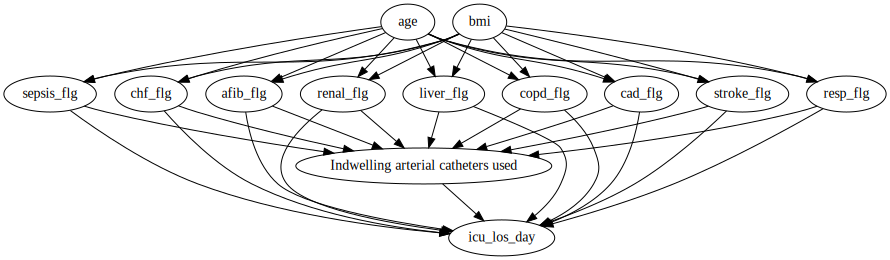

In [6]:

causal_graph = """digraph {
aline_flg[label="Indwelling arterial catheters used"];

age -> sepsis_flg;
age -> chf_flg;
age -> afib_flg;
age -> renal_flg;
age -> liver_flg;
age -> copd_flg;
age -> cad_flg;
age -> stroke_flg;
age -> resp_flg;
bmi -> sepsis_flg;
bmi -> chf_flg;
bmi -> afib_flg;
bmi -> renal_flg;
bmi -> liver_flg;
bmi -> copd_flg;
bmi -> cad_flg;
bmi -> stroke_flg;
bmi -> resp_flg;
sepsis_flg -> aline_flg;
chf_flg -> aline_flg;
afib_flg -> aline_flg;
renal_flg -> aline_flg;
liver_flg -> aline_flg;
copd_flg -> aline_flg;
cad_flg -> aline_flg;
stroke_flg -> aline_flg;
resp_flg -> aline_flg;
sepsis_flg -> icu_los_day;
chf_flg -> icu_los_day;
afib_flg -> icu_los_day;
renal_flg -> icu_los_day;
liver_flg -> icu_los_day;
copd_flg -> icu_los_day;
cad_flg -> icu_los_day;
stroke_flg -> icu_los_day;
resp_flg -> icu_los_day;
aline_flg -> icu_los_day;
}"""

g = graphviz.Source(causal_graph)
display(g)

### Next, we use `ehrapy` to perform causal inference on the data.

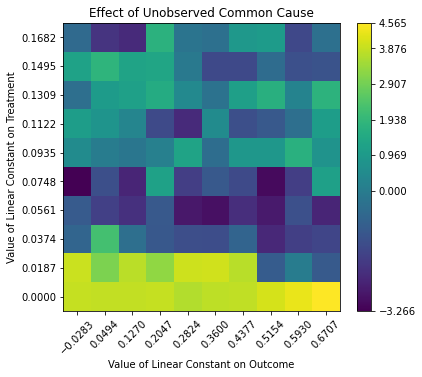

Causal inference results for treatment variable 'aline_flg' and outcome variable 'icu_los_day':
└- Increasing the treatment variable(s) [aline_flg] from 0 to 1 causes an increase of 3.8764921409656874 in the expected value of the outcome [icu_los_day], over the data distribution/population represented by the dataset.

Refutation results
├-Refute: placebo_treatment_refuter
|    └- Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by NearestNeighbors.
├-Refute: Add a random common cause
|    ├- Estimated effect: 3.88
|    ├- New effect: 3.88
|    ├- p-value: 2.00
|    └- Test significance: 3.88
├-Refute: Use a subset of data
|    ├- Estimated effect: 3.88
|    ├- New effect: 2.36
|    ├- p-value: 0.08
|    └- Test significance: 3.88
└-Refute: Add an Unobserved Common Cause
     ├- Estimated effect: 3.88
     ├- New effect: -3.27, 4.56
     ├- p-value: Not applicable
     └- Test significance: 3.88



In [7]:
estimate = ep.tl.causal_inference(
    adata=adata, 
    graph=causal_graph, 
    treatment="aline_flg", 
    outcome="icu_los_day", 
    estimation_method="backdoor.propensity_score_matching",
    refute_methods=[
        "placebo_treatment_refuter", 
        "random_common_cause", 
        "data_subset_refuter", 
        "add_unobserved_common_cause"
    ],
    return_as="estimate",
    print_summary=True,
    show_refute_plots=True,
)

Similariy, we can use a different estimation method which then allows us to plot the estimator.

<Axes: title={'center': 'DoWhy estimate $\\rho$ (slope) = 2.235'}, xlabel='aline_flg', ylabel='icu_los_day'>

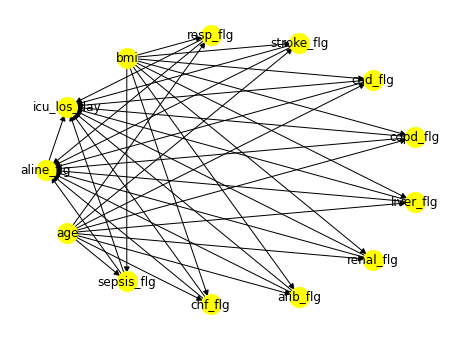

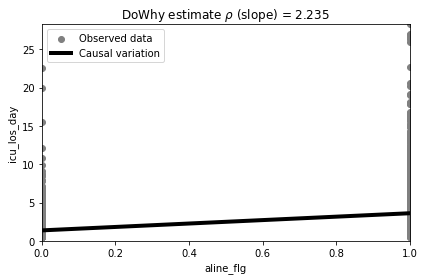

In [8]:
estimate = ep.tl.causal_inference(
    adata=adata, 
    graph=causal_graph, 
    treatment="aline_flg", 
    outcome="icu_los_day", 
    estimation_method="backdoor.linear_regression",
    refute_methods=[
        "placebo_treatment_refuter", 
        "random_common_cause", 
        "data_subset_refuter", 
        "add_unobserved_common_cause"
    ],
    return_as="estimate",
    print_summary=False,
    show_graph=True,
    show_refute_plots=False,
)
ep.tl.plot_causal_effect(estimate)